<a href="https://colab.research.google.com/github/gladysadyaz/Hybrid-VAR-LSTM/blob/main/Forecast_of_Hybrid_ExRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import warnings
import itertools
import statsmodels.api as sm
import tensorflow.keras as keras
import seaborn as sns
import tensorflow as tf
import gc

from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import *
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from numpy import array

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [28]:
pd.options.display.float_format = '{:.2f}'.format

# MODELING

# B. LONG SHORT TERM MEMORY

## Splitting & Scaling

In [2]:
file_path_actual = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df_actual = pd.read_excel(file_path_actual, sheet_name='Sheet1')
df_actual['Date'] = pd.to_datetime(df_actual['Date'], format='%d/%m/%Y')
df_actual.set_index('Date', inplace=True)
print(df_actual.head())

             Kurs  Wisman Bali  Hari Raya
Date                                     
2023-01-01  15592        10626          1
2023-01-02  15572        12338          1
2023-01-03  15590        12122          1
2023-01-04  15615        11957          1
2023-01-05  15610        13463          1


In [3]:
file_path = "/content/drive/My Drive/Colab Notebooks/varx_residuals.xlsx"
df = pd.read_excel(file_path, sheet_name='all')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

             Kurs  Wisman Bali
Date                          
2023-01-02 -21.05         1703
2023-01-03   0.49         2032
2023-01-04  20.58         2030
2023-01-05  15.84         3819
2023-01-06  41.33         3618


In [4]:
steps_slicing = 90
df_final = df_actual[:-steps_slicing]
df_update = df_actual[-steps_slicing:]

In [5]:
df_final

,Kurs,Wisman Bali,Hari Raya
Date,,,
2023-01-01,15592,10626,1
2023-01-02,15572,12338,1
2023-01-03,15590,12122,1
2023-01-04,15615,11957,1
2023-01-05,15610,13463,1
...,...,...,...
2024-10-18,15466,21046,0
2024-10-19,15466,19986,0
2024-10-20,15466,20564,1


In [6]:
df_update

,Kurs,Wisman Bali,Hari Raya
Date,,,
2024-10-23,15620,19314,0
2024-10-24,15593,18771,0
2024-10-25,15629,20254,0
2024-10-26,15629,18288,0
2024-10-27,15629,18408,0
...,...,...,...
2025-01-16,16378,18021,0
2025-01-17,16373,19190,0
2025-01-18,16373,18652,1


In [7]:
# Select only the 'Kurs Dollar' column for input and output
df_residual = df['Kurs']
data2 = df_residual.copy()
data2

,Kurs
Date,
2023-01-02,-21.05
2023-01-03,0.49
2023-01-04,20.58
2023-01-05,15.84
2023-01-06,41.33
...,...
2025-01-16,12.75
2025-01-17,15.31
2025-01-18,15.91


In [8]:
# Normalize the data for LSTM
scaler2 = MinMaxScaler()
scaled_data2 = scaler2.fit_transform(data2.values.reshape(-1, 1))

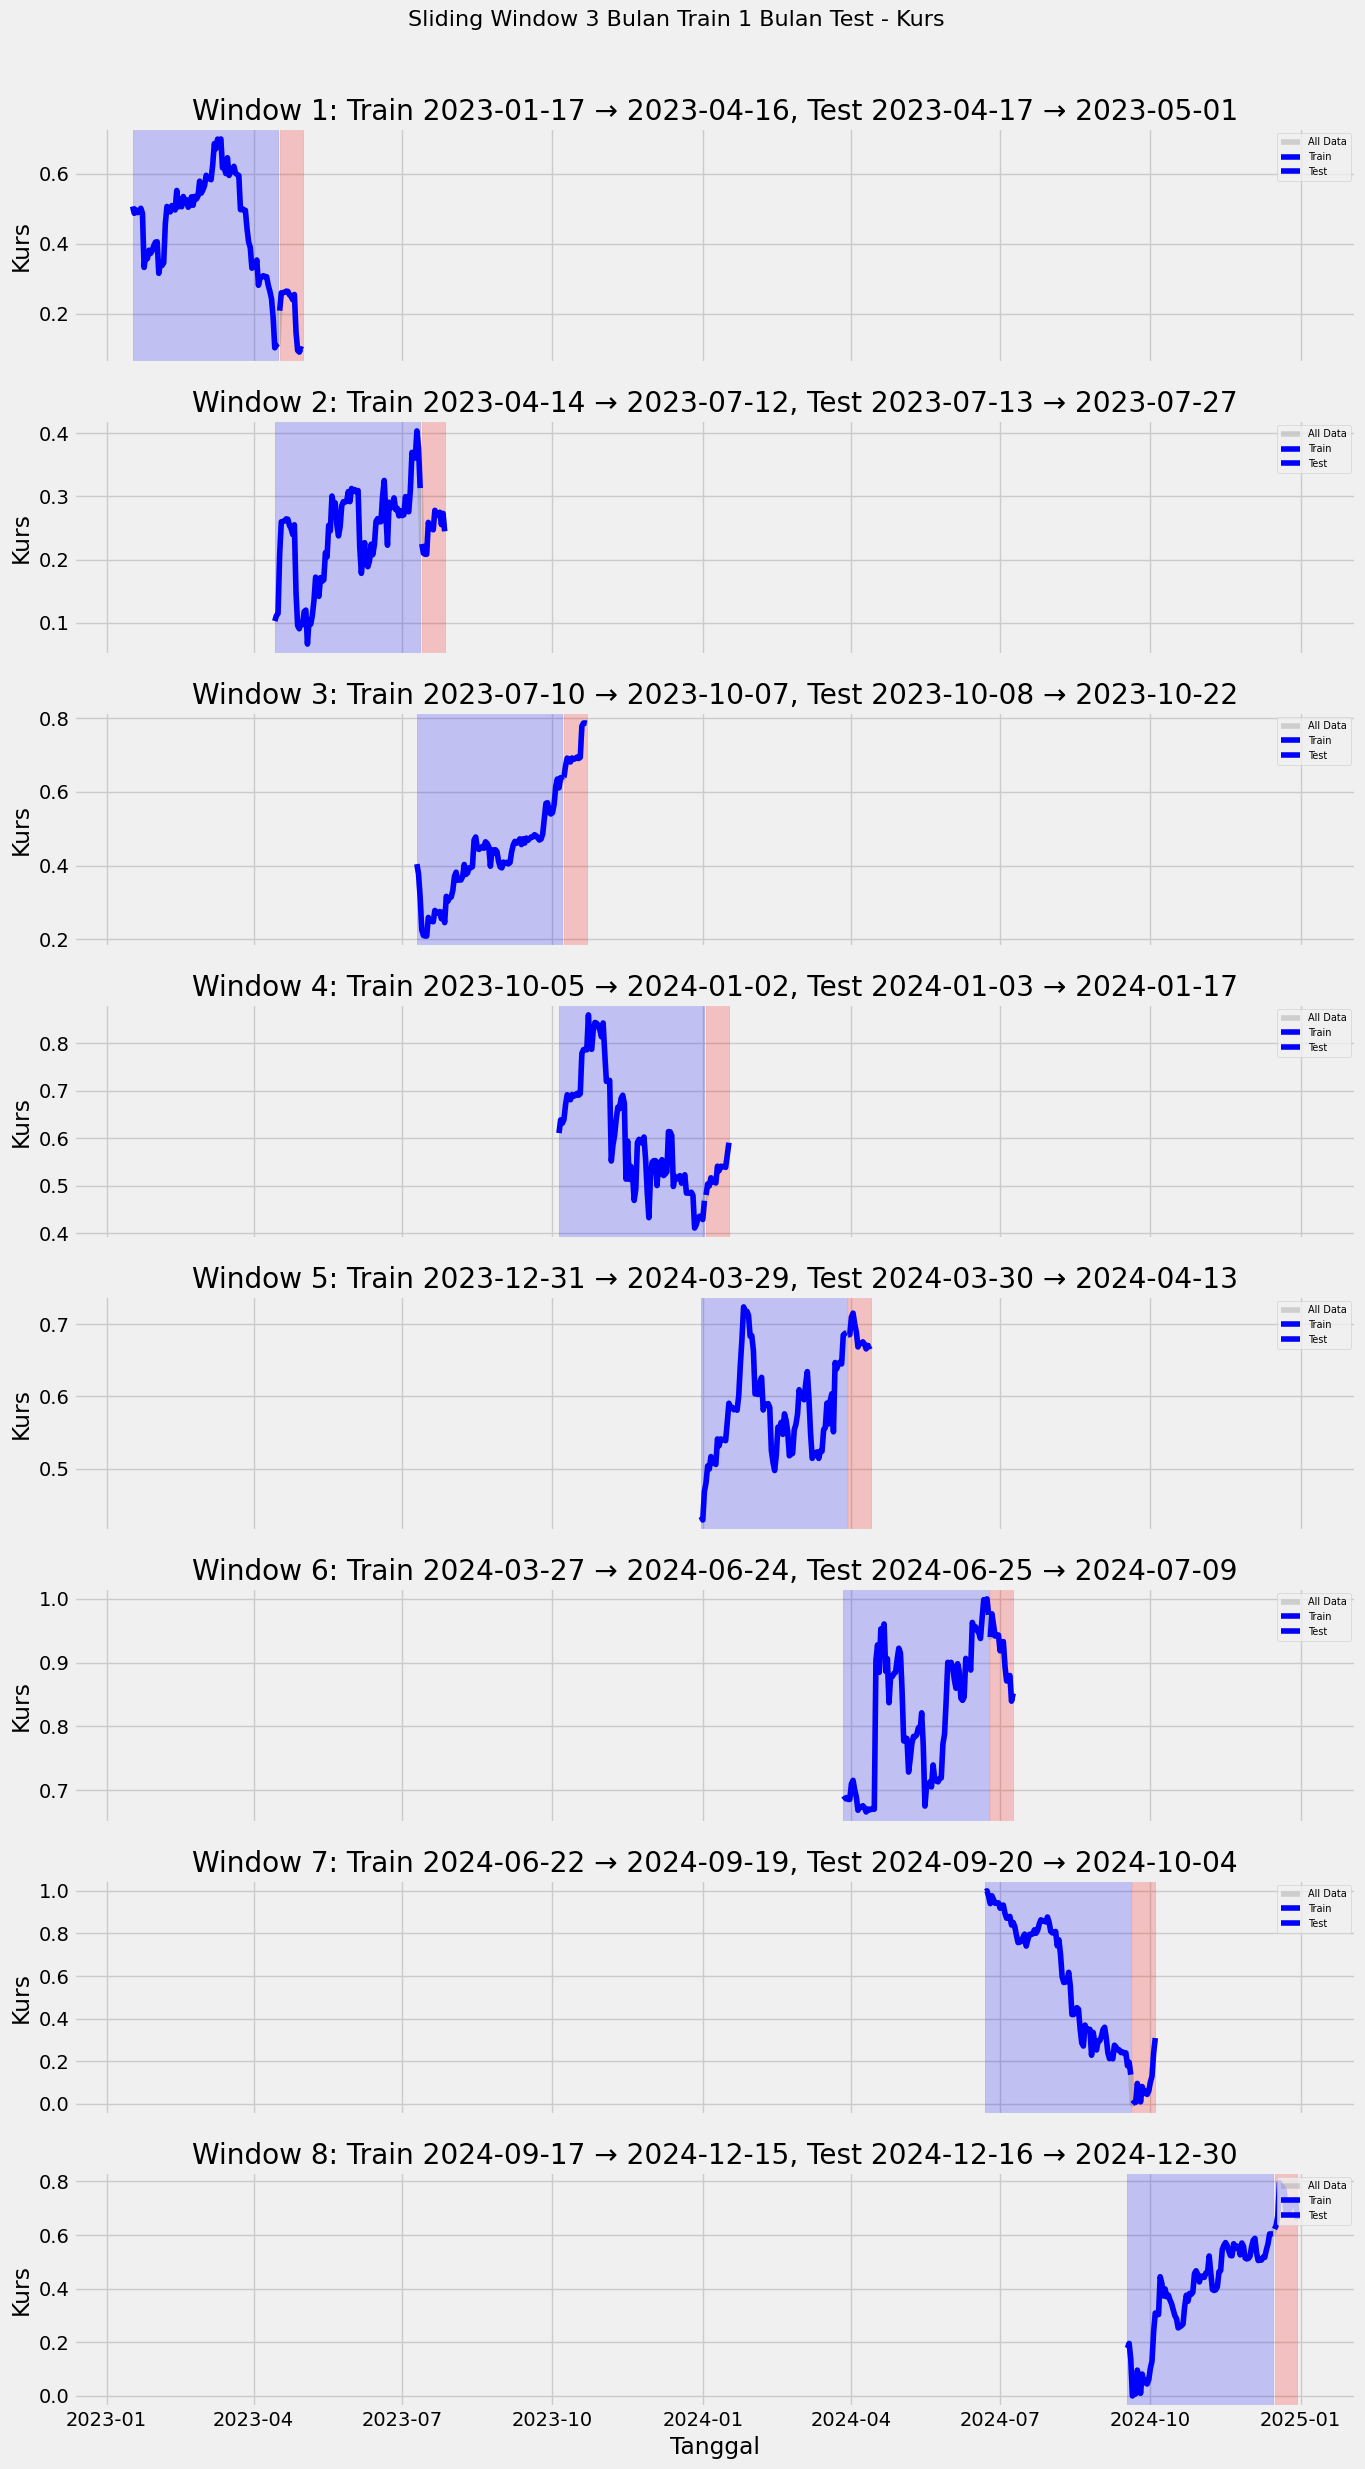

In [9]:
# Konversi kembali ke DataFrame agar bisa diproses fungsi plot
scaled_data2_df = pd.DataFrame(scaled_data2, index=data2.index, columns=['Kurs'])

# Parameter sliding window
n_train = 90
n_test = 30
window_size = n_train + n_test  # = 120
shift = 87
n_windows = 8
n_total = len(scaled_data2_df)

# Fungsi plotting sliding window
def plot_windows(df, var, color, label):
    fig, axes = plt.subplots(n_windows, 1, figsize=(14, 26), sharex=True)

    for i in range(n_windows):
        start, end = i * shift, i * shift + window_size
        if end > n_total:
            print(f"Window {i+1} out of bounds.")
            break

        window_data = df.iloc[start + 15:end]  # Potong 1 hari di awal window
        train = window_data.iloc[:n_train]
        test = window_data.iloc[n_train:]
        ax = axes[i]

        ax.plot(window_data.index, window_data[var], color='gray', alpha=0.3, label='All Data')
        ax.axvspan(train.index[0], train.index[-1], color='blue', alpha=0.2)
        ax.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2)
        ax.plot(train.index, train[var], color=color, label='Train')
        ax.plot(test.index, test[var], color=color, label='Test')

        ax.set_title(f"Window {i+1}: Train {train.index[0].date()} → {train.index[-1].date()}, Test {test.index[0].date()} → {test.index[-1].date()}")
        ax.set_ylabel(label)
        ax.legend(loc='upper right', fontsize=7)

    plt.xlabel("Tanggal")
    plt.suptitle(f"Sliding Window 3 Bulan Train 1 Bulan Test - {label}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Plot variabel 'Kurs'
plot_windows(scaled_data2_df, 'Kurs', 'blue', 'Kurs')

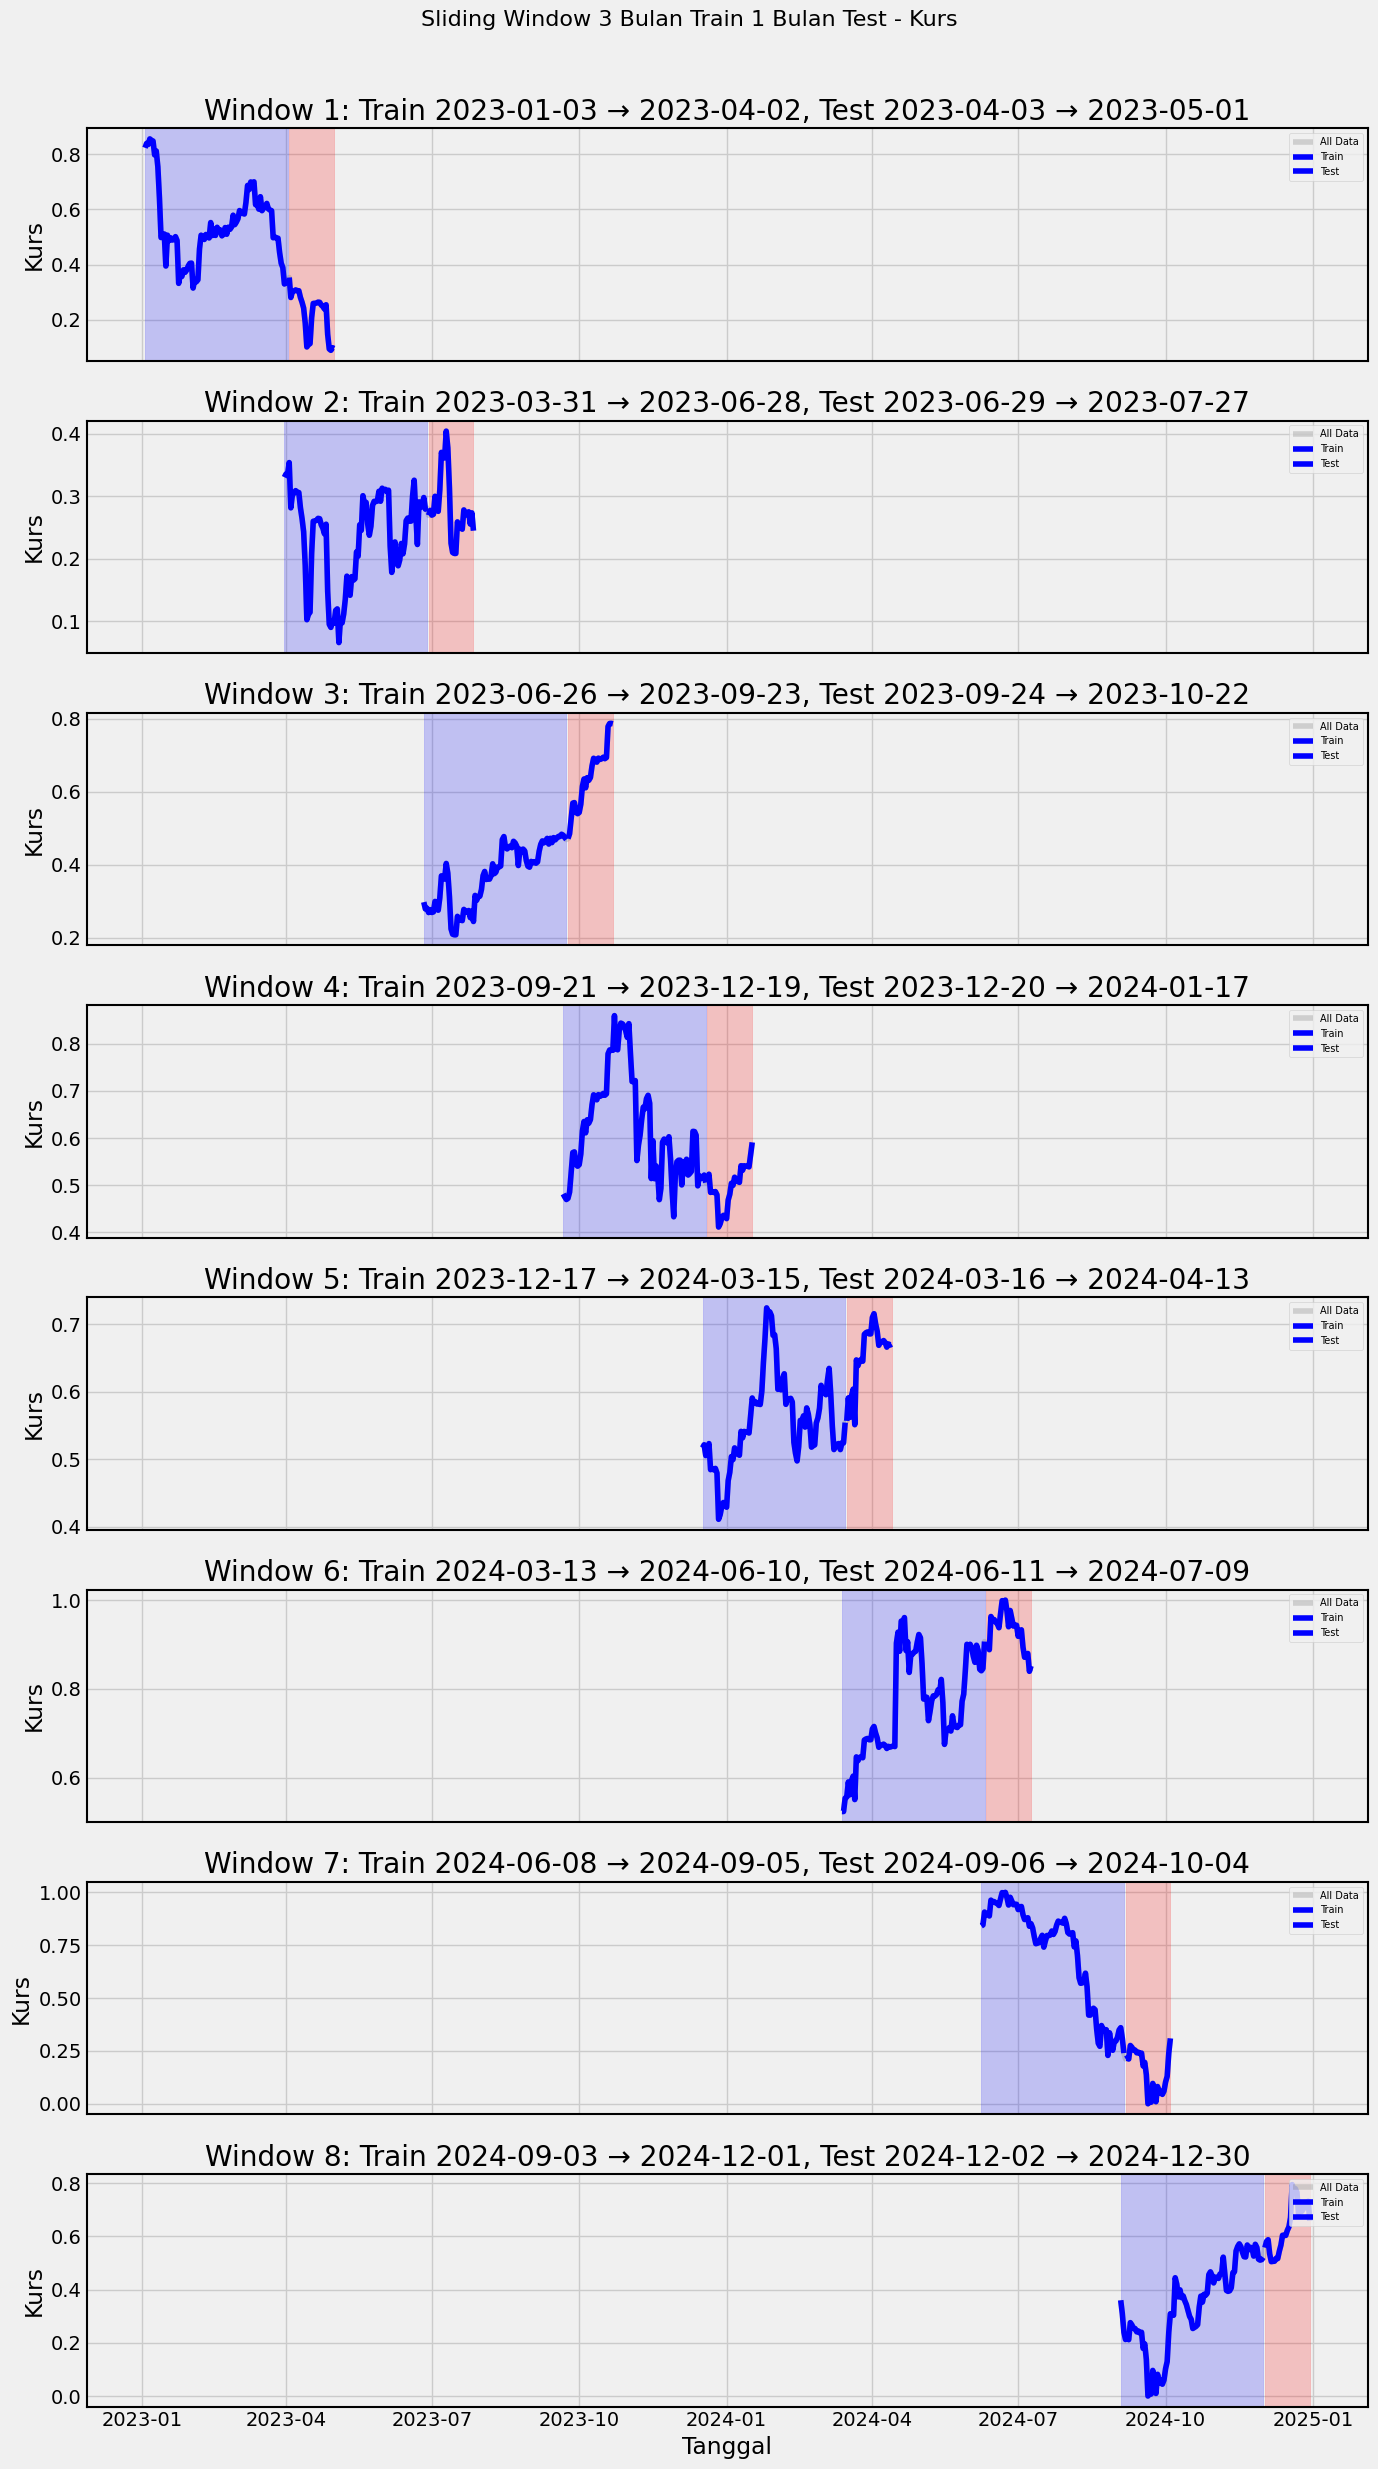

In [10]:
def plot_windows(df, var, color, label):
    fig, axes = plt.subplots(n_windows, 1, figsize=(14, 26), sharex=True)

    for i in range(n_windows):
        start, end = i * shift, i * shift + window_size
        if end > len(df):
            print(f"Window {i+1} out of bounds.")
            break

        window_data = df.iloc[start + 1:end]
        train = window_data.iloc[:n_train]
        test = window_data.iloc[n_train:]
        ax = axes[i]

        ax.plot(window_data.index, window_data[var], color='gray', alpha=0.3, label='All Data')
        ax.axvspan(train.index[0], train.index[-1], color='blue', alpha=0.2)
        ax.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2)
        ax.plot(train.index, train[var], color=color, label='Train')
        ax.plot(test.index, test[var], color=color, label='Test')

        ax.set_title(f"Window {i+1}: Train {train.index[0].date()} → {train.index[-1].date()}, Test {test.index[0].date()} → {test.index[-1].date()}")
        ax.set_ylabel(label)
        ax.legend(loc='upper right', fontsize=7)

        # Tambahkan bingkai (spines) di setiap axes
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)

    plt.xlabel("Tanggal")
    plt.suptitle(f"Sliding Window 3 Bulan Train 1 Bulan Test - {label}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Plot variabel 'Kurs'
plot_windows(scaled_data2_df, 'Kurs', 'blue', 'Kurs')

In [11]:
# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]  # Use only the first column
        dataX.append(a)
        dataY.append(data[i + time_step, 0])  # Use only the first column
    return np.array(dataX), np.array(dataY)

In [12]:
# Set the time step
time_step = 15

# Create the dataset for LSTM
X2, y2 = create_dataset(scaled_data2, time_step)

# Reshape X2 to be [samples, time steps, features] which is required for LSTM
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)

In [13]:
test_size2 = 90
train_size2 = len(X2) - test_size2
X2_train, X2_test = X2[:train_size2], X2[train_size2:]
y2_train, y2_test = y2[:train_size2], y2[train_size2:]

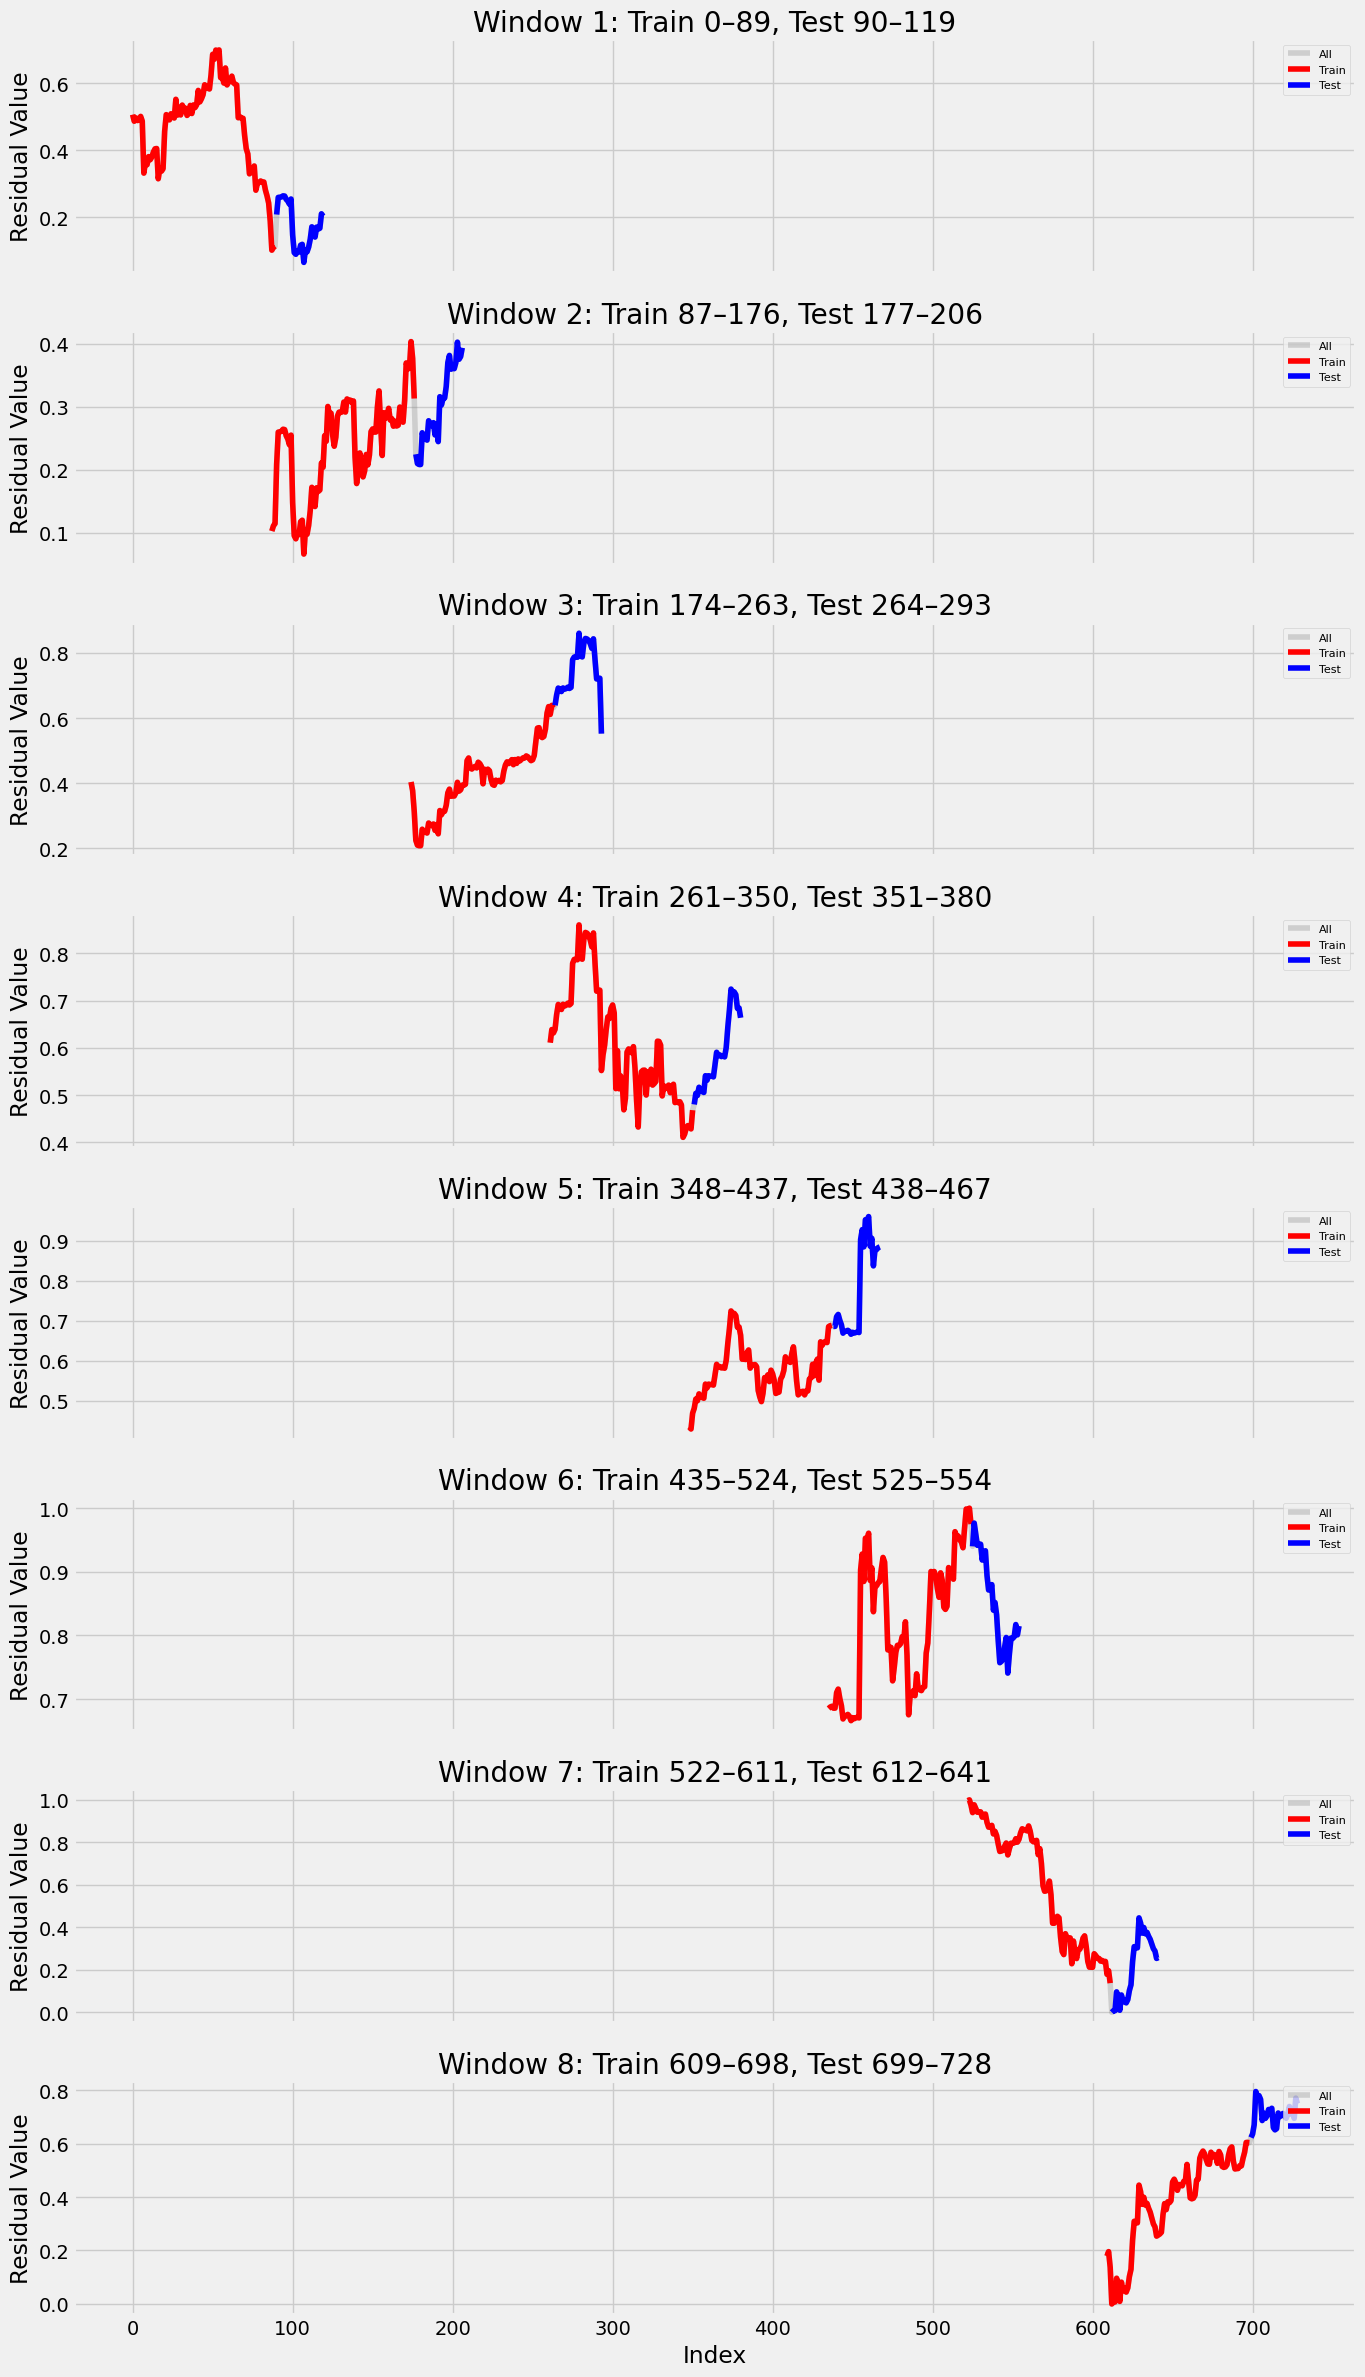

In [14]:
def plot_sliding_windows_vertical(y, train_size=90, test_size=30, shift=87, n_windows=8):
    y = y.flatten()
    total_len = len(y)


    fig, axs = plt.subplots(n_windows, 1, figsize=(14, 3 * n_windows), sharex=True)


    for i in range(n_windows):
        start_train = shift * i
        end_train = start_train + train_size
        end_test = end_train + test_size


        if end_test > total_len:
            break


        ax = axs[i]


        # Plot all data background (optional)
        ax.plot(range(start_train, end_test), y[start_train:end_test], color='gray', alpha=0.3, label='All')


        # Plot train (merah)
        ax.plot(range(start_train, end_train), y[start_train:end_train], color='red', label='Train')


        # Plot test (biru)
        ax.plot(range(end_train, end_test), y[end_train:end_test], color='blue', label='Test')


        ax.set_title(f'Window {i+1}: Train {start_train}–{end_train-1}, Test {end_train}–{end_test-1}')
        ax.set_ylabel('Residual Value')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True)


    plt.xlabel('Index')
    plt.tight_layout()
    plt.show()


# Versi vertikal dengan shift 87
plot_sliding_windows_vertical(y2, train_size=90, test_size=30, shift=87, n_windows=8)


## Hypertuning Parameters

In [15]:
# Function to create model for LSTM
def create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme):
    seed_value = 54
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(time_step, 1), kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(units=units2, kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='linear', kernel_initializer=init_scheme))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [16]:
# Define the hyperparameter grid for LSTM
param_grid_lstm2 = {
 'units1': [50],
 'units2': [100],
 'dropout_rate':[0.2],
 'learning_rate': [0.01],
 'batch_size': [16],
 'epochs': [100],
 'init_scheme': ['glorot_uniform']
  }

In [17]:
from itertools import product
# Convert param_grid to a list of dictionaries
param_list_lstm2 = list(product(param_grid_lstm2['units1'],
                                param_grid_lstm2['units2'],
                                param_grid_lstm2['dropout_rate'],
                                param_grid_lstm2['learning_rate'],
                                param_grid_lstm2['batch_size'],
                                param_grid_lstm2['epochs'],
                                param_grid_lstm2['init_scheme'],))

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# Fungsi SMAPE
def smape(A, F):
    A, F = np.array(A), np.array(F)
    return np.mean(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))) * 100

# Inisialisasi variabel untuk tracking model terbaik
best_score_lstm2 = float('inf')
best_params_lstm2 = None
best_model_lstm2 = None

# Ukuran train-test dan shifting antar window
train_sz = 90
test_sz = 30
shift = 87

# Loop untuk grid search dengan parameter dari param_list_lstm2
for params in tqdm(param_list_lstm2):
    val_smape_scores = []
    units1, units2, dropout_rate, learning_rate, batch_size, epochs, init_scheme = params

    for i in range(8):
        idx_train = train_sz + shift * i
        idx_test = train_sz + test_sz + shift * i

        # Split data
        X2_train, X2_test = X2[:idx_train], X2[idx_train:idx_test]
        y2_train, y2_test = y2[:idx_train], y2[idx_train:idx_test]

        # Buat model LSTM2
        model_lstm2 = create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme)

        # Callback early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Training
        model_lstm2.fit(
            X2_train, y2_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X2_test, y2_test),
            callbacks=[early_stopping],
            verbose=0
        )

        # Prediksi dan inverse transform
        y2_test_pred = model_lstm2.predict(X2_test)
        y2_test_pred_denorm = scaler2.inverse_transform(y2_test_pred).flatten()
        y2_test_denorm = scaler2.inverse_transform(y2_test.reshape(-1, 1)).flatten()

        # Hitung SMAPE
        smape_score = smape(y2_test_denorm, y2_test_pred_denorm)
        val_smape_scores.append(smape_score)

        print(f"SMAPE window {i+1}: {smape_score:.4f}")

    # Hitung rata-rata SMAPE dari 8 window
    smape_avg = np.mean(val_smape_scores)

    # Simpan jika ini model terbaik sejauh ini
    if smape_avg < best_score_lstm2:
        best_score_lstm2 = smape_avg
        best_params_lstm2 = {
            'units1': units1,
            'units2': units2,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'init_scheme': init_scheme
        }
        best_model_lstm2 = model_lstm2

# Print hasil akhir
print(f"Best LSTM2 average SMAPE: {best_score_lstm2:.2f}%")
print(f"Best parameters: {best_params_lstm2}")

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
SMAPE window 1: 11.1223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
SMAPE window 2: 8.1326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
SMAPE window 3: 79.4413
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
SMAPE window 4: 12.6279


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
SMAPE window 5: 45.1629


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
SMAPE window 6: 62.6944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
SMAPE window 7: 7.5036
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


100%|██████████| 1/1 [00:56<00:00, 56.70s/it]

SMAPE window 8: 27.3648
Best LSTM2 average SMAPE: 31.76%
Best parameters: {'units1': 50, 'units2': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100, 'init_scheme': 'glorot_uniform'}


## Model

In [19]:
best_params_lstm2

{'units1': 50,
 'units2': 100,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'batch_size': 16,
 'epochs': 100,
 'init_scheme': 'glorot_uniform'}

In [20]:
# Re-split data untuk pelatihan akhir model (bukan CV)
test_size2 = 90
train_size2 = len(X2) - test_size2

X2_train = X2[:train_size2]
X2_test = X2[train_size2:]
y2_train = y2[:train_size2]
y2_test = y2[train_size2:]

# Ambil parameter terbaik dari hasil grid search
manual_units1_lstm2 = best_params_lstm2['units1']
manual_units2_lstm2 = best_params_lstm2['units2']
manual_dropout_rate_lstm2 = best_params_lstm2['dropout_rate']
manual_learning_rate_lstm2 = best_params_lstm2['learning_rate']
manual_batch_size_lstm2 = best_params_lstm2['batch_size']
manual_epochs_lstm2 = best_params_lstm2['epochs']
manual_init_scheme_lstm2 = best_params_lstm2['init_scheme']

# Buat model dengan parameter terbaik
model_manual_lstm2 = create_model_lstm2(manual_units1_lstm2,
                                        manual_units2_lstm2,
                                        manual_dropout_rate_lstm2,
                                        manual_learning_rate_lstm2,
                                        manual_init_scheme_lstm2)

# Early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

# Latih model dengan parameter terbaik
history_manual_lstm2 = model_manual_lstm2.fit(X2_train,
                                              y2_train,
                                              batch_size=manual_batch_size_lstm2,
                                              epochs=manual_epochs_lstm2,
                                              validation_data=(X2_test, y2_test),
                                              callbacks=[early_stopping],
                                              verbose=1)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0690 - val_loss: 0.0030
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0029
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

In [21]:
# Summary model
model_manual_lstm2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 15, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,705 (830.88 KB)

 Trainable params: 70,901 (276.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 141,804 (553.93 KB)

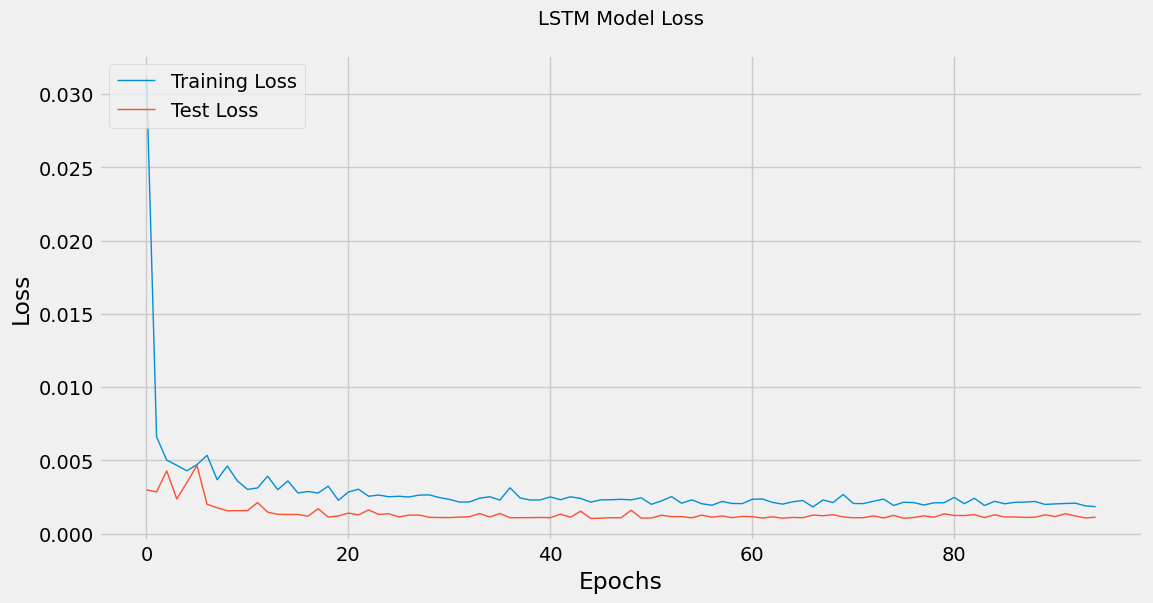

In [22]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(history_manual_lstm2.history['loss'], label='Training Loss', linewidth=1)
plt.plot(history_manual_lstm2.history['val_loss'], label='Test Loss', linewidth=1)
plt.title('LSTM Model Loss\n', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [23]:
# Predict on the training data for LSTM
train_predict_lstm2 = model_manual_lstm2.predict(X2_train)
test_predict_lstm2 = model_manual_lstm2.predict(X2_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [24]:
# Inverse transform the predictions for LSTM
train_predict_lstm2 = scaler2.inverse_transform(train_predict_lstm2)
test_predict_lstm2 = scaler2.inverse_transform(test_predict_lstm2)
y2_train = scaler2.inverse_transform(y2_train.reshape(-1, 1))
y2_test = scaler2.inverse_transform(y2_test.reshape(-1, 1))

## Forecasting



In [25]:
# Forecasting for the next 14 steps
predictions_lstm2 = []
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(14):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [26]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Kurs Dollar'])

# Assuming df_update is the dataframe where you want to align future predictions, here aligning index with the valid_data's last 7 steps.
dates = pd.date_range(start="2025-01-21", periods=14, freq='D')
df_future_predictions_lstm2.index = dates

# Display the future predictions DataFrame
df_future_predictions_lstm2


,Predicted Residual Kurs Dollar
2025-01-21,2.327185
2025-01-22,-1.320772
2025-01-23,-3.862293
2025-01-24,-6.005926
2025-01-25,-8.101275
2025-01-26,-10.199812
2025-01-27,-12.318924
2025-01-28,-14.461418
2025-01-29,-16.556463
2025-01-30,-18.597910


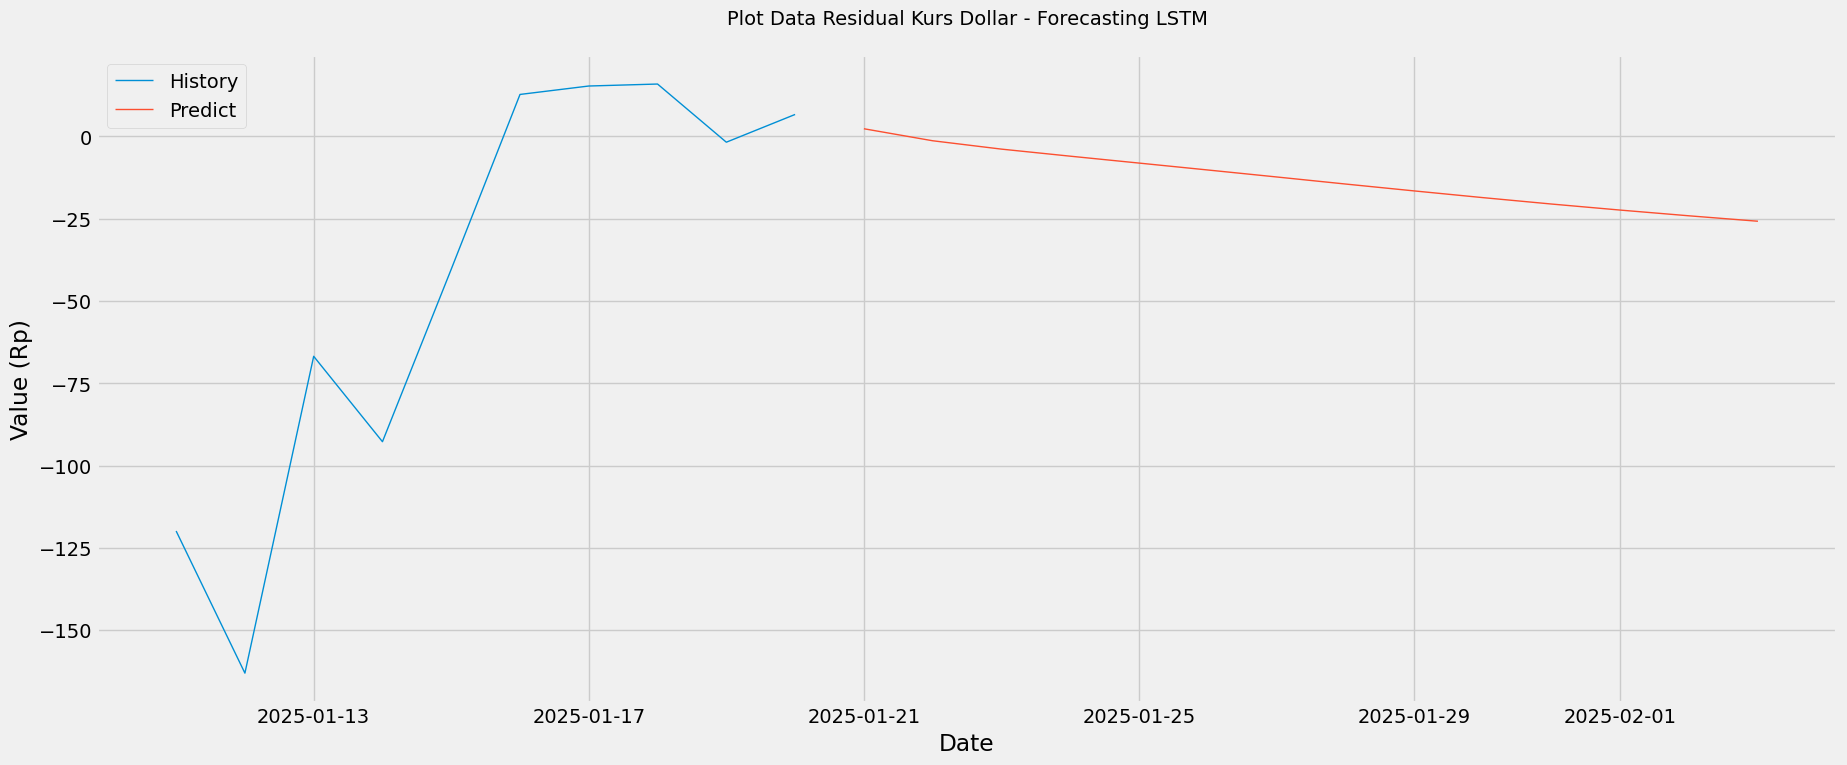

In [27]:
# Plot Data
plt.figure(figsize=(20, 8))
plt.plot(df.iloc[-10:]['Kurs'], linewidth=1, label='History')
plt.plot(df_future_predictions_lstm2['Predicted Residual Kurs Dollar'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Residual Kurs Dollar - Forecasting LSTM\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# C. HYBRID VAR-LSTM

#Forecast 14 Hari

In [29]:
file_path_forecast = "/content/drive/My Drive/Colab Notebooks/varx_forecast.xlsx"
df_forecast = pd.read_excel(file_path_forecast, sheet_name='FIXVAR')
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'], format='%d/%m/%Y')
df_forecast.set_index('Date', inplace=True)
print(df_forecast.head())

               Kurs  Wisman Bali
Date                            
2024-10-23 15563.19        19031
2024-10-24 15556.90        19251
2024-10-25 15558.64        20218
2024-10-26 15557.91        19982
2024-10-27 15553.73        20022


In [30]:
file_path_forecast = "/content/drive/My Drive/Colab Notebooks/varx_forecast.xlsx"
df_forecast = pd.read_excel(file_path_forecast, sheet_name='FIXVAR')
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'], format='%d/%m/%Y')
df_forecast.set_index('Date', inplace=True)
print(df_forecast.head())

               Kurs  Wisman Bali
Date                            
2024-10-23 15563.19        19031
2024-10-24 15556.90        19251
2024-10-25 15558.64        20218
2024-10-26 15557.91        19982
2024-10-27 15553.73        20022


In [31]:
# Forecasting for the next 14 steps
predictions_lstm2 = []
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(14):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [32]:
dates = pd.date_range(start="2025-01-21", periods=14, freq='D')

In [33]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Kurs Dollar'])
df_future_predictions_lstm2.index = dates

# Display the future predictions DataFrame
df_future_predictions_lstm2

,Predicted Residual Kurs Dollar
2025-01-21,2.33
2025-01-22,-1.32
2025-01-23,-3.86
2025-01-24,-6.01
2025-01-25,-8.10
2025-01-26,-10.20
2025-01-27,-12.32
2025-01-28,-14.46
2025-01-29,-16.56
2025-01-30,-18.60


In [34]:
df_linear = df_forecast[['Kurs']]
df_linear14 = df_linear[-14:]
df_linear14

,Kurs
Date,
2025-01-21,16384.70
2025-01-22,16390.14
2025-01-23,16393.47
2025-01-24,16392.80
2025-01-25,16392.92
2025-01-26,16391.10
2025-01-27,16392.70
2025-01-28,16395.95
2025-01-29,16396.64


In [35]:
df_nonlinear = df_future_predictions_lstm2.copy()
df_nonlinear

,Predicted Residual Kurs Dollar
2025-01-21,2.33
2025-01-22,-1.32
2025-01-23,-3.86
2025-01-24,-6.01
2025-01-25,-8.10
2025-01-26,-10.20
2025-01-27,-12.32
2025-01-28,-14.46
2025-01-29,-16.56
2025-01-30,-18.60


In [36]:
df_hybrid = pd.DataFrame({
    'Hybrid Kurs Dollar': df_linear14['Kurs'] + df_nonlinear['Predicted Residual Kurs Dollar'],
})
df_hybrid

,Hybrid Kurs Dollar
Date,
2025-01-21,16387.03
2025-01-22,16388.82
2025-01-23,16389.61
2025-01-24,16386.79
2025-01-25,16384.82
2025-01-26,16380.90
2025-01-27,16380.38
2025-01-28,16381.49
2025-01-29,16380.08


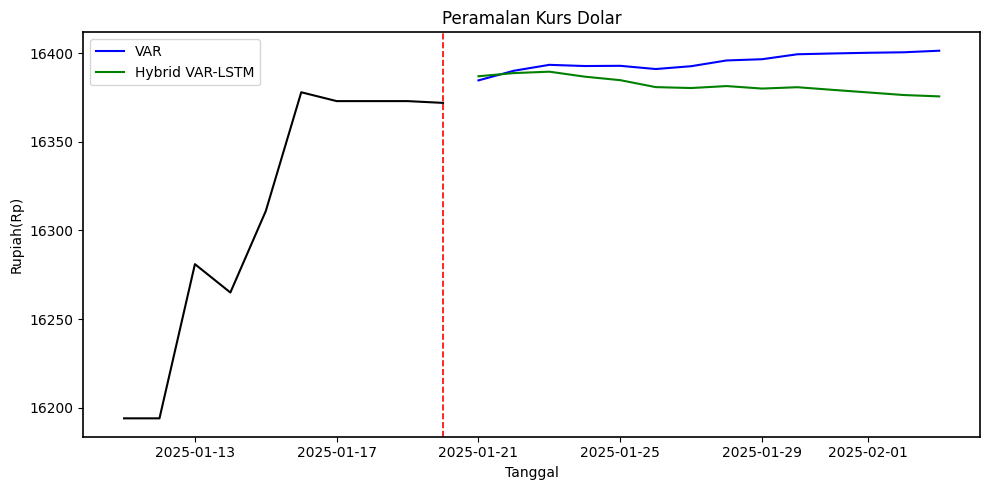

In [37]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.style.use('default')


fig, ax = plt.subplots(figsize=(10,5))  # buat figure dan axes secara eksplisit

# plot di axes yang sudah dibuat
ax.plot(df_update.index[-10:], df_update['Kurs'][-10:],color='black', linewidth=1.5)
ax.plot(df_linear14.index, df_linear14, label='VAR', color='blue', linewidth=1.5)
ax.plot(df_hybrid.index, df_hybrid, label='Hybrid VAR-LSTM', color='green', linewidth=1.5)

cutoff_date = df_update.index[-1]
ax.axvline(x=cutoff_date, color='red', linestyle='--', linewidth=1.2)

# hilangkan grid dalam (kotak bantu)
ax.grid(False)

# pastikan semua spines aktif dan terlihat
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(1.2)

# label dan judul
ax.set_title('Peramalan Kurs Dolar')
ax.set_xlabel('Tanggal')
ax.set_ylabel('Rupiah(Rp)')
ax.legend()

plt.tight_layout()
plt.show()